### Loading data

In [3]:
# import os

# # from google.colab import drive
# # drive.mount('/content/drive')

# folders = os.listdir()
# if 'CNS_EOG' not in folders:
#     !git clone https://github.com/JRodrigoF/CNS_EOG.git

In [1]:
import scipy.io as sio
import pandas as pd
import numpy as np
import datetime
import os, sys
import random
import gc

from plotnine import *
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

prefix_path = 'data/eog_office/'

mat_files = sorted([f for f in os.listdir(prefix_path) if f.endswith('.mat')])

column_names = ['seconds', 'microseconds', 'EOG_H', 'EOG_V', 'class']

data = []
for file in mat_files:
    mat = sio.loadmat(prefix_path + file)
    participant = file.split('_')[0].replace('participant', '')
    exp_run = file.split('_')[1].replace('.mat', '')

    df = (
        pd.DataFrame(mat['data'], columns=column_names)
        .assign(activity=lambda x: x['class']
                .replace({1: 'null', 2: 'read', 3: 'browse', 4: 'write',
                        5: 'video', 6: 'copy', 7: 'disspeak', 8: 'disphone'})
                .astype('category')
                )
        .assign(unix_time=lambda x: x['seconds'] + (x['microseconds'] / 1000000))
        .assign(participant=lambda x: participant)
        .assign(exp_run=lambda x: exp_run)
        .assign(sex=lambda x: x['participant']
                .replace({'1': 'male', '2': 'male', '3': 'male', '4': 'male',
                        '5': 'male', '6': 'female', '7': 'female', '8': 'male'})
                .astype('category')
                )
        .assign(time_normalized=lambda x: x['unix_time'] - x['seconds'][0])
        .assign(full_date=lambda x: pd.to_datetime(x['seconds'], unit='s')
                .astype('datetime64'))
        .assign(date=lambda x: pd.to_datetime(x['seconds'], unit='s').dt.date
                .astype('datetime64'))
        .assign(time=lambda x: pd.to_datetime(x['seconds'], unit='s').dt.time)
    )

    new_dtypes = {"class": 'category', 'participant': 'category',
                    'exp_run': 'category', 'time': 'string'}
    df = df.astype(new_dtypes)
    data.append(df)

rand_exp = int(random.sample(range(1,15),1)[0])

display("Random experiment: ", rand_exp)
display(data[rand_exp])
display(data[rand_exp].dtypes)

'Random experiment: '

12

,seconds,microseconds,EOG_H,EOG_V,class,activity,unix_time,participant,exp_run,sex,time_normalized,full_date,date,time
0,1237798381,201404,1614980,957495,4,write,1.237798e+09,7,0,female,0.201404,2009-03-23 08:53:01,2009-03-23,08:53:01
1,1237798381,201437,1611732,953241,4,write,1.237798e+09,7,0,female,0.201437,2009-03-23 08:53:01,2009-03-23,08:53:01
2,1237798381,209426,1624336,954679,4,write,1.237798e+09,7,0,female,0.209426,2009-03-23 08:53:01,2009-03-23,08:53:01
3,1237798381,210099,1622142,946810,4,write,1.237798e+09,7,0,female,0.210099,2009-03-23 08:53:01,2009-03-23,08:53:01
4,1237798381,216395,1623814,954802,4,write,1.237798e+09,7,0,female,0.216395,2009-03-23 08:53:01,2009-03-23,08:53:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182382,1237800148,84379,1449200,929815,5,video,1.237800e+09,7,0,female,1767.084379,2009-03-23 09:22:28,2009-03-23,09:22:28
182383,1237800148,112405,1451675,928931,5,video,1.237800e+09,7,0,female,1767.112405,2009-03-23 09:22:28,2009-03-23,09:22:28
182384,1237800148,112443,1453190,926176,5,video,1.237800e+09,7,0,female,1767.112443,2009-03-23 09:22:28,2009-03-23,09:22:28
182385,1237800148,120433,1457329,928139,5,video,1.237800e+09,7,0,female,1767.120433,2009-03-23 09:22:28,2009-03-23,09:22:28


seconds                     int32
microseconds                int32
EOG_H                       int32
EOG_V                       int32
class                    category
activity                 category
unix_time                 float64
participant              category
exp_run                  category
sex                      category
time_normalized           float64
full_date          datetime64[ns]
date               datetime64[ns]
time                       string
dtype: object

### Visual overview

#### Raw data | Table format

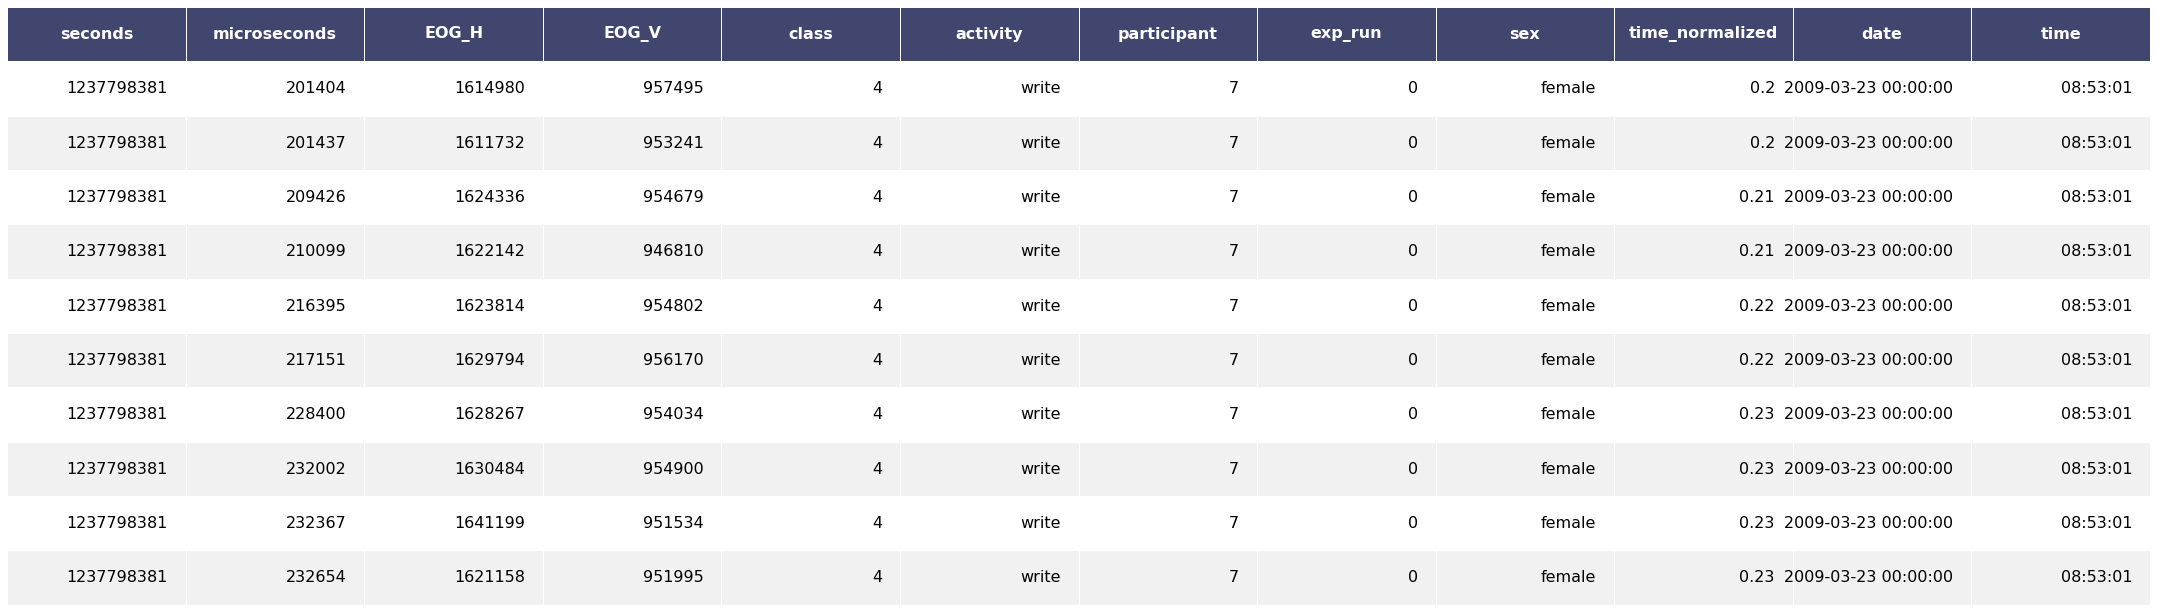

In [3]:
sample = (data[rand_exp].head(10)
        .assign(time_normalized=lambda x: round(x['time_normalized'],2))
        .drop(['unix_time', 'full_date'], axis=1)
)

# display(sample)

import matplotlib.pyplot as plt

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=15,
                    header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                    bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(sample, header_columns=0, row_height=1, col_width=3.2, font_size=16)
fig.savefig("imgs/raw_data_tables/Raw_data_table.png")


#### Raw data | Plot format

In [4]:
from utils.plotnine_grid import plotnine_grid

sample_preffixes = [f.replace('_', '_run_')
                .replace('participant', 'Participant_')
                .replace('.mat', '') for f in mat_files]

sample_titles = [f.replace('_', ' ') for f in sample_preffixes]

brewer_set = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', 
                '#ff7f00', '#ffff33', '#a65628', '#f781bf']

brewer_paired = ["#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C", "#FB9A99", "#E31A1C",
                "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A", "#FFFF99", "#B15928"]

raw_data_plots = sorted([f for f in os.listdir("imgs/eog_data/")
                        if f.startswith('Participant_') and f.endswith('.png')])

def two_panel_plot(data, x, y1, y2, color_by_1, color_by_2, plot_title,
                x_lab, color_palette, size=0.4, alpha=0.9, index=None, out_plot=None):
        
        if index != None:
                data_frame = data[index]
        else:
                data_frame = data
                
        p = ggplot(data_frame)
        p = p + geom_line(aes(x, y1, color=color_by_1),
                        size=size, alpha=alpha)
        p = p + scale_color_manual(color_palette)
        p = p + labs(x=x_lab, y='EOG H', title=plot_title)
        p = p + theme_classic()
        p = p + theme(legend_key=element_rect(color = "white"))
        # display(p)

        q = ggplot(data_frame)
        q = q + geom_line(aes(x, y2, color=color_by_2),
                        size=size, alpha=alpha)
        q = q + scale_color_manual(color_palette)
        q = q + labs(x=x_lab, y='EOG V', title=plot_title)
        q = q + theme_classic()
        q = q + theme(legend_key=element_rect(color = "white"))
        # display(p)

        plotnine_grid([p, q], row=None, col=1, height=4, width=6, dpi=300,
                ratio=None, pixels=10000, figsize=(12, 8), file=out_plot)
                
if len(raw_data_plots) != 16:
        for i in range(len(data)):
                ordered_categories = list(data[i]['activity'].unique())
                data[i] =  data[i].assign(activity=pd.Categorical(
                        data[i]['activity'], ordered_categories))
                
                out_plot='imgs/eog_data/{}.png'.format(sample_preffixes[i])
                plot_title="Raw Data \n{}".format(sample_titles[i])
                x_lab="time (re-scaled)"
                x='time_normalized'
                y1='EOG_H'
                y2='EOG_V'
                color_by_1='activity'
                color_by_2='activity'
                
                two_panel_plot(data, x, y1, y2, color_by_1, color_by_2,
                        plot_title, x_lab, color_palette=brewer_set,
                        size=0.4, alpha=0.9, index=i, out_plot=out_plot)
                        

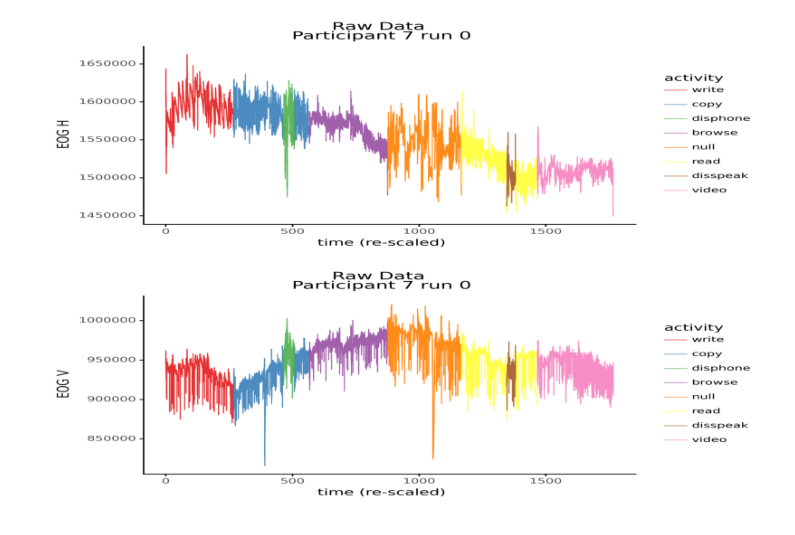

In [5]:
# Example plot
# %pylab inline

import matplotlib.image as img

plt.figure(figsize = (14,10))
img = img.imread('imgs/eog_data/' + raw_data_plots[rand_exp])
plt.axis('off')
plt.imshow(img)
plt.show()

### Filtering

#### Flagging of atypical experimental runs

After visual inspection of the raw data, I decided to flag one experiment as follows:

- Participant 08 run 01

    - Atypical run, specially vertical movements which never move around 0. Predictive models should test if accuracy improves after removing this run.

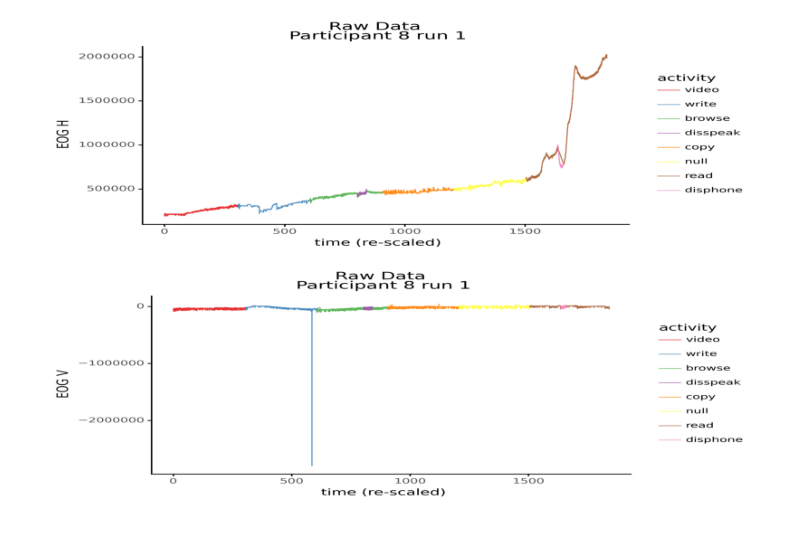

In [7]:
import matplotlib.image as img

plt.figure(figsize = (14,10))
img = img.imread('imgs/eog_data/Participant_8_run_1.png')
plt.axis('off')
plt.imshow(img)
plt.show()

### De-noising

#### Median Filter

In [9]:
from scipy.signal import medfilt

medfilt_plots = sorted([f for f in os.listdir("imgs/median_filters")
                        if f.startswith('Participant_') and f.endswith('.png')])
# rand_exp = 1

for i in range(len(data)):
        data[i]['EOG_V_MedFilt'] = medfilt(data[i].EOG_V, kernel_size=5)
        data[i]['EOG_H_MedFilt'] = medfilt(data[i].EOG_H, kernel_size=5)

medfilt_data = []

for i in range(len(data)):

        medfilt_data_1 = (pd.DataFrame({
                "time": list(range(1,len(data[i].EOG_V)+1)),
                "Raw_EOG_V": list(data[i].EOG_V),
                "scipy_signal_medfilt_EOG_V": list(data[i].EOG_V_MedFilt)})
                .melt(var_name='median_filter_EOG_V', value_name='signal_EOG_V',
                id_vars=['time'],  value_vars=['Raw_EOG_V', 'scipy_signal_medfilt_EOG_V']))
        # display(medfilt_data_1)

        medfilt_data_2 = (pd.DataFrame({
                "time": list(range(1,len(data[i].EOG_V)+1)),
                "Raw_EOG_H": list(data[i].EOG_H),
                "scipy_signal_medfilt_EOG_H": list(data[i].EOG_H_MedFilt)})
                .melt(var_name='median_filter_EOG_H', value_name='signal_EOG_H',
                id_vars=['time'],  value_vars=['Raw_EOG_H', 'scipy_signal_medfilt_EOG_H']))
        # display(medfilt_data_2)

        medfilt_data.append(medfilt_data_1.merge(medfilt_data_2, on='time'))

if len(medfilt_plots) != 16:
        for i in range(len(data)):
                out_plot='imgs/median_filters/{}.png'.format(sample_preffixes[i])
                plot_title='Median Filter\n{}'.format(sample_titles[i])
                x_lab="time (re-scaled)"
                x='time'
                # y='signal'
                y1='signal_EOG_H'
                y2='signal_EOG_V'
                color_by_1='median_filter_EOG_H'
                color_by_2='median_filter_EOG_V'
                
                two_panel_plot(medfilt_data, x, y1, y2, color_by_1, color_by_2,
                        plot_title, x_lab, color_palette=brewer_set,
                        size=0.3, alpha=0.7, index=i, out_plot=out_plot)

del medfilt_data
gc.collect()

# Implemented alternatives for baseline drift removal: 

# .- [tested] eog_clean() from the library neurokit.
# .- [tested] pandas.rolling_median(data, window=5, center=True)

3129

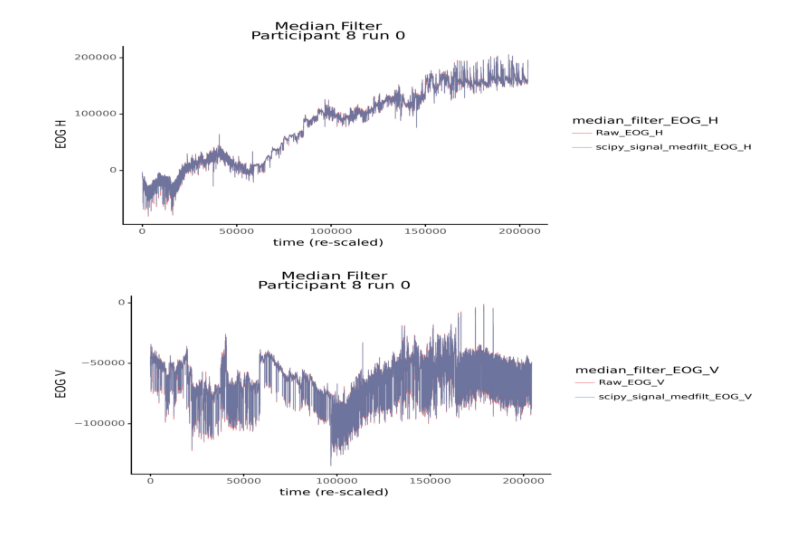

In [9]:
# Example plot
import matplotlib.image as img

plt.figure(figsize = (14,10))
img = img.imread('imgs/median_filters/' + medfilt_plots[rand_exp])
plt.axis('off')
plt.imshow(img)
plt.show()

In [21]:
temp = rand_exp
rand_exp = 0

medfilt_data_zoom_1 = (pd.DataFrame({
    "time": list(range(8000,8600)),
    "Raw_EOG_V": list(data[rand_exp].EOG_V[8000:8600]),
    "scipy_signal_medfilt_EOG_V": list(data[rand_exp].EOG_V_MedFilt[8000:8600])})
    .melt(var_name='median_filter_EOG_V', value_name='signal_EOG_V',
    id_vars=['time'],  value_vars=['Raw_EOG_V', 'scipy_signal_medfilt_EOG_V']))
# display(medfilt_data_zoom_1)

medfilt_data_zoom_2 = (pd.DataFrame({
    "time": list(range(8000,8600)),
    "Raw_EOG_H": list(data[rand_exp].EOG_H[8000:8600]),
    "scipy_signal_medfilt_EOG_H": list(data[rand_exp].EOG_H_MedFilt[8000:8600])})
    .melt(var_name='median_filter_EOG_H', value_name='signal_EOG_H',
    id_vars=['time'],  value_vars=['Raw_EOG_H', 'scipy_signal_medfilt_EOG_H']))
# display(medfilt_data_zoom_2)

medfilt_data_zoom = medfilt_data_zoom_1.merge(medfilt_data_zoom_2, on='time')
# display(medfilt_data_zoom)

out_plot='imgs/median_filters/Zoom_{}.png'.format(sample_preffixes[rand_exp])
plot_title='[Zoom] Median Filter\n{}'.format(sample_titles[rand_exp])
x_lab="time (re-scaled)"
x='time'
y1='signal_EOG_H'
y2='signal_EOG_V'
color_by_1='median_filter_EOG_H'
color_by_2='median_filter_EOG_V'

two_panel_plot(medfilt_data_zoom, x, y1, y2, color_by_1, color_by_2,
        plot_title, x_lab, color_palette=brewer_set, size=0.3, alpha=0.7,
        index=None, out_plot=out_plot)

rand_exp = temp

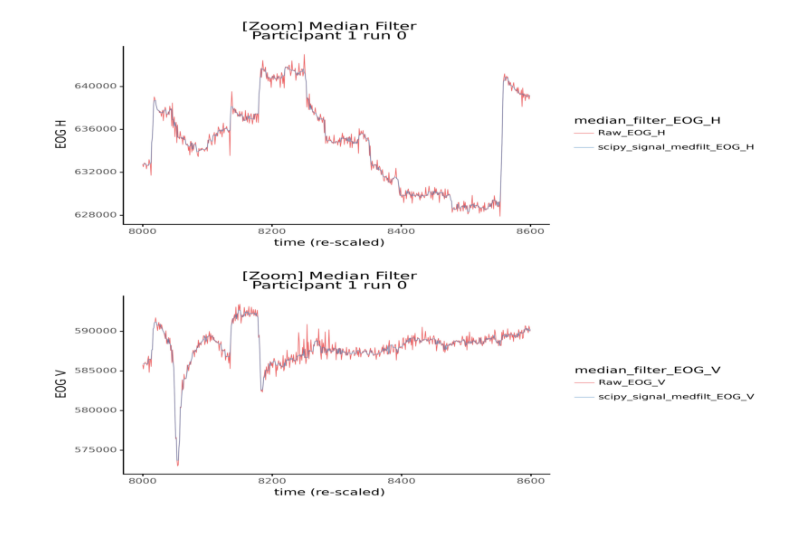

In [25]:
import matplotlib.image as img

plt.figure(figsize = (14,10))
img = img.imread(out_plot)
plt.axis('off')
plt.imshow(img)
plt.show()

#### Baseline Wander Removal

In [33]:
from utils.bwr import calc_baseline
from BaselineRemoval import BaselineRemoval

basedrift_plots = sorted([f for f in os.listdir("imgs/baseline_drift_removal")
                        if f.startswith('Participant_') and f.endswith('.png')])

# rand_exp = 1

polynomial_degree = 2 # only needed for Modpoly and IModPoly algorithm

for i in range(len(data)):

        # Baseline Wander Removal with Wavelet Transform
        # https://github.com/spebern/py-bwr
        data[i]['EOG_H_BWR_BS'] = data[i].EOG_H_MedFilt - calc_baseline(data[i].EOG_H_MedFilt)
        data[i]['EOG_V_BWR_BS'] = data[i].EOG_V_MedFilt - calc_baseline(data[i].EOG_V_MedFilt)

        # Baseline Removal using Python implementation of Modified polyfit method, IModPoly method and Zhang fit method for baseline removal
        # https://pypi.org/project/BaselineRemoval/
        EOG_H_BRP_BL = BaselineRemoval(data[i].EOG_H_MedFilt)
        EOG_V_BRP_BL = BaselineRemoval(data[i].EOG_V_MedFilt)

        data[i]['EOG_H_BRP_Imod_d2'] = EOG_H_BRP_BL.IModPoly(polynomial_degree)
        data[i]['EOG_V_BRP_Imod_d2'] = EOG_V_BRP_BL.IModPoly(polynomial_degree)

basedrift_filt_data = []

for i in range(len(data)):

        basedrift_filt_data_1 = (pd.DataFrame({
                "time": list(range(1,len(data[i].EOG_H)+1)),
                "scipy_signal_medfilt_EOG_H": list(data[i].EOG_H_MedFilt),
                "BWR_EOG_H": list(data[i].EOG_H_BWR_BS),
                "BRP_Imod_d2_EOG_H": list(data[i].EOG_H_BRP_Imod_d2)})
                .melt(var_name='baseline_drift_filter_EOG_H', value_name='signal_EOG_H',
                id_vars=['time'],  value_vars=['scipy_signal_medfilt_EOG_H', 'BWR_EOG_H', 'BRP_Imod_d2_EOG_H']))
        # display(basedrift_filt_data_1)

        basedrift_filt_data_2 = (pd.DataFrame({
                "time": list(range(1,len(data[i].EOG_V)+1)),
                "scipy_signal_medfilt_EOG_V": list(data[i].EOG_V_MedFilt),
                "BWR_EOG_V": list(data[i].EOG_V_BWR_BS),
                "BRP_Imod_d2_EOG_V": list(data[i].EOG_V_BRP_Imod_d2)})
                .melt(var_name='baseline_drift_filter_EOG_V', value_name='signal_EOG_V',
                id_vars=['time'],  value_vars=['scipy_signal_medfilt_EOG_V', 'BWR_EOG_V', 'BRP_Imod_d2_EOG_V']))
        # display(basedrift_filt_data_2)

        basedrift_filt_data.append(basedrift_filt_data_1.merge(basedrift_filt_data_2, on='time'))

# display(basedrift_filt_data[0])

if len(basedrift_plots) != 16:
        for i in range(len(data)):
                out_plot='imgs/baseline_drift_removal/{}.png'.format(sample_preffixes[i])
                plot_title='Baseline Drift Removal\n{}'.format(sample_titles[i])
                x_lab="time (re-scaled)"
                x='time'
                y1='signal_EOG_H'
                y2='signal_EOG_V'
                color_by_1='baseline_drift_filter_EOG_H'
                color_by_2='baseline_drift_filter_EOG_V'
                
                two_panel_plot(basedrift_filt_data, x, y1, y2, color_by_1, color_by_2,
                        plot_title, x_lab, color_palette=brewer_set,
                        size=0.3, alpha=0.7, index=i, out_plot=out_plot)
                        
# Implemented alternatives for baseline drift removal: 

# .- [tested] Baseline Wander Removal with Notch filter fro Python Heart Rate Analysis
# https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/_modules/heartpy/filtering.html
# .- [tested] Baseline Removal using "Asymmetric Least Squares Smoothing" by P. Eilers and H. Boelens
# https://stackoverflow.com/questions/29156532/python-baseline-correction-library


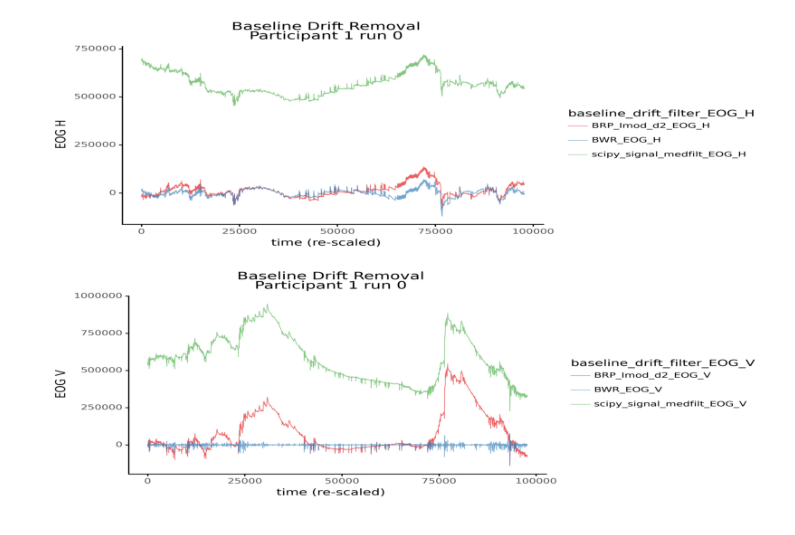

In [34]:
# Example plot
import matplotlib.image as img

plt.figure(figsize = (14,10))
img = img.imread('imgs/baseline_drift_removal/' + basedrift_plots[0])
plt.axis('off')
plt.imshow(img)
plt.show()

### Eye Movement Modelling

#### Filtered data to .mat files

In [35]:
BRP_mat_files = sorted([f for f in os.listdir("data/eog_processed/")
                        if f.startswith('Participant_') and f.endswith('BRP.mat')])

BWR_mat_files = sorted([f for f in os.listdir("data/eog_processed/")
                        if f.startswith('Participant_') and f.endswith('BWR.mat')])

if len(BRP_mat_files) != 16 and len(BWR_mat_files) != 16:

        for i in range(len(data)):
                out_mat='data/eog_processed/{}_BWR.mat'.format(sample_preffixes[i])
                
                temp_BWR = ({
                        'fs': np.array([[128.0]]),
                        'EOGh': np.array([list(data[i]['EOG_H_BWR_BS'])]), 
                        'EOGv': np.array([list(data[i]['EOG_V_BWR_BS'])])
                })
                # display(temp_BWR)
                sio.savemat(out_mat, temp_BWR)

                out_mat='data/eog_processed/{}_BRP.mat'.format(sample_preffixes[i])
                
                temp_BRP = ({
                        'fs': np.array([[128.0]]),
                        'EOGh': np.array([list(data[i]['EOG_H_BRP_Imod_d2'])]), 
                        'EOGv': np.array([list(data[i]['EOG_V_BRP_Imod_d2'])])
                })
                # display(temp_BRP)
                sio.savemat(out_mat, temp_BRP)

#### Matlab eye movement calculation

In [45]:
# Block intended to run MATLAB code (eogert_mode.mat) from the notebook

# import matlab.engine

prefix_path = 'data/eog_eye_movements/'

BRP_feature_mat_files = sorted([f for f in os.listdir(prefix_path) if f.endswith('BRP_eye_features.mat')])
BWR_feature_mat_files = sorted([f for f in os.listdir(prefix_path) if f.endswith('BWR_eye_features.mat')])

if len(BRP_feature_mat_files) != 16 and len(BWR_feature_mat_files) != 16:
    pass

#     eng = matlab.engine.start_matlab()
#     eng.eogert_mod(nargout=0)
#     eng.quit()


#### Eye movement data into dataframes

In [46]:
# Blinks and saccades could not be estimated for all experimental runs
# thus, we use dummy empty dataframes for such cases

dummy_blinks = (pd.DataFrame.from_dict({
    'BLI_START': [0],
    'BLI_END': [0],
    'BLI_DUR': [0],
    'BLI_PROB': [0]})
    )
display(dummy_blinks)

dummy_saccades = (pd.DataFrame.from_dict({
    'SAC_START': [0],
    'SAC_END': [0],
    'SAC_DUR': [0],
    'SAC_PROB': [0]})
    )
display(dummy_saccades)

,BLI_START,BLI_END,BLI_DUR,BLI_PROB
0,0,0,0,0


,SAC_START,SAC_END,SAC_DUR,SAC_PROB
0,0,0,0,0


In [47]:
prefix_path = 'data/eog_eye_movements/'

BRP_feature_mat_files = sorted([f for f in os.listdir(prefix_path) if f.endswith('BRP_eye_features.mat')])
BWR_feature_mat_files = sorted([f for f in os.listdir(prefix_path) if f.endswith('BWR_eye_features.mat')])

BRP_blink_data = []
BWR_blink_data = []
BRP_sac_data = []
BWR_sac_data = []

# BRP data
for i in range(len(BRP_feature_mat_files)):
    
    mat_data = sio.loadmat(prefix_path + BRP_feature_mat_files[i])
    # display(mat_data.keys())
    
    if 'BLI_START' in mat_data.keys():
        temp_blink = (pd.DataFrame.from_dict({
            'BLI_START': mat_data['BLI_START'].tolist()[0],
            'BLI_DUR': mat_data['BLI_DUR'].tolist()[0],
            'BLI_PROB': mat_data['BLI_PROB'].tolist()[0],
            })
            .assign(BLI_END=lambda x: x['BLI_START'] + x['BLI_DUR'])
            .filter(items=['BLI_START', 'BLI_END', 'BLI_DUR', 'BLI_PROB'])
            )
            
        BRP_blink_data.append(temp_blink)
    else:
        BRP_blink_data.append(dummy_blinks)
    if i == 14:
        BRP_blink_data.append(dummy_blinks)
        
    # display(BRP_blink_data)
        
    if 'SAC_START' in mat_data.keys():
        temp_sac = (pd.DataFrame.from_dict({
            'SAC_START': mat_data['SAC_START'].tolist()[0],
            'SAC_DUR': mat_data['SAC_DUR'].tolist()[0],
            'SAC_PROB': mat_data['SAC_PROB'].tolist()[0],
            })
            .assign(SAC_END=lambda x: x['SAC_START'] + x['SAC_DUR'])
            .filter(items=['SAC_START', 'SAC_END', 'SAC_DUR', 'SAC_PROB'])
            )
        
        BRP_sac_data.append(temp_sac)
    else:
        BRP_sac_data.append(dummy_saccades)
    if i == 14:
        BRP_sac_data.append(dummy_saccades)
    # display(BRP_sac_data)        
        
# BWR data
for i in range(len(BWR_feature_mat_files)):
    
    mat_data = sio.loadmat(prefix_path + BWR_feature_mat_files[i])
    
    if 'BLI_START' in mat_data.keys():
        temp_blink = (pd.DataFrame.from_dict({
            'BLI_START': mat_data['BLI_START'].tolist()[0],
            'BLI_DUR': mat_data['BLI_DUR'].tolist()[0],
            'BLI_PROB': mat_data['BLI_PROB'].tolist()[0],
            })
            .assign(BLI_END=lambda x: x['BLI_START'] + x['BLI_DUR'])
            .filter(items=['BLI_START', 'BLI_END', 'BLI_DUR', 'BLI_PROB'])
            )
            
        BWR_blink_data.append(temp_blink)
    else:
        BWR_blink_data.append(dummy_blinks)
    # display(BWR_blink_data)
        
    if 'SAC_START' in mat_data.keys():
        temp_sac = (pd.DataFrame.from_dict({
            'SAC_START': mat_data['SAC_START'].tolist()[0],
            'SAC_DUR': mat_data['SAC_DUR'].tolist()[0],
            'SAC_PROB': mat_data['SAC_PROB'].tolist()[0],
            })
            .assign(SAC_END=lambda x: x['SAC_START'] + x['SAC_DUR'])
            .filter(items=['SAC_START', 'SAC_END', 'SAC_DUR', 'SAC_PROB'])
            )
        BWR_sac_data.append(temp_sac)
    else:
        BWR_sac_data.append(dummy_saccades)
    # display(BWR_sac_data)

# index = 8
# display(BRP_blink_data[index])
# display(BRP_sac_data[index])
# display(BWR_blink_data[index])
# display(BWR_sac_data[index])

In [48]:
new_features = []

for i in range(len(data)):

    data_temp = data[i].filter(items=['time_normalized']) #  ['time_normalized']

    data_temp = (data_temp
                .assign(time_norm_end = list(data_temp['time_normalized'][1:]) + [1800.0])
                .assign(BRP_eye_movement = lambda x: 'None')
                .assign(BRP_eye_movement_prob = lambda x: 0)
                .assign(BWR_eye_movement = lambda x: 'None')
                .assign(BWR_eye_movement_prob = lambda x: 0)
    )
    new_features.append(data_temp)
    
# display(new_features[0][3440:3450])
# new_features[0].head()
# new_features[0]

In [62]:
final_eye_movements = []

extended_data_tables = sorted([f for f in os.listdir("data/eog_extended_tables/")
                        if f.startswith('Participant_') and f.endswith('extended_table.tsv.gz')])

if len(extended_data_tables) != 16:

    for i in range(len(data)):
        
        print("Progress {} out of {}".format(i+1,len(data)))
        
        new_features_dict = new_features[i].to_dict('list')
        
        BRP_blink_data_dict = BRP_blink_data[i].to_dict('list')
        BRP_sac_data_dict = BRP_sac_data[i].to_dict('list')
        BWR_blink_data_dict = BWR_blink_data[i].to_dict('list')
        BWR_sac_data_dict = BWR_sac_data[i].to_dict('list')
        
        # display(new_features_dict[i].keys())
        # display(new_features_dict[i])
        
        # BRP data
        for i in range(len(new_features_dict['time_normalized'])):
            # blink_data
            for j in range(len(BRP_blink_data_dict['BLI_START'])):
                if new_features_dict['time_normalized'][i] >= BRP_blink_data_dict['BLI_START'][j] and new_features_dict['time_norm_end'][i] <= BRP_blink_data_dict['BLI_END'][j]:
                    new_features_dict['BRP_eye_movement'][i] = 'blink'
                    new_features_dict['BRP_eye_movement_prob'][i] = BRP_blink_data_dict['BLI_PROB'][j]
                    break

        # for i in range(len(new_features_dict['time_normalized'])):
            # saccades_data
            for j in range(len(BRP_sac_data_dict['SAC_START'])):
                if new_features_dict['time_normalized'][i] >= BRP_sac_data_dict['SAC_START'][j] and new_features_dict['time_norm_end'][i] <= BRP_sac_data_dict['SAC_END'][j]:
                    new_features_dict['BRP_eye_movement'][i] = 'saccade'
                    new_features_dict['BRP_eye_movement_prob'][i] = BRP_sac_data_dict['SAC_PROB'][j]
                    break
                
        # BWR data
        for i in range(len(new_features_dict['time_normalized'])):
            # blink_data
            for j in range(len(BWR_blink_data_dict['BLI_START'])):
                if new_features_dict['time_normalized'][i] >= BWR_blink_data_dict['BLI_START'][j] and new_features_dict['time_norm_end'][i] <= BWR_blink_data_dict['BLI_END'][j]:
                    new_features_dict['BWR_eye_movement'][i] = 'blink'
                    new_features_dict['BWR_eye_movement_prob'][i] = BWR_blink_data_dict['BLI_PROB'][j]
                    break
                
        # for i in range(len(new_features_dict['time_normalized'])):
            # saccades_data
            for j in range(len(BWR_sac_data_dict['SAC_START'])):
                if new_features_dict['time_normalized'][i] >= BWR_sac_data_dict['SAC_START'][j] and new_features_dict['time_norm_end'][i] <= BWR_sac_data_dict['SAC_END'][j]:
                    new_features_dict['BWR_eye_movement'][i] = 'saccade'
                    new_features_dict['BWR_eye_movement_prob'][i] = BWR_sac_data_dict['SAC_PROB'][j]
                    break 

        temp_data = (pd.DataFrame({
            'time_normalized' : new_features_dict['time_normalized'],
            'time_norm_end' : new_features_dict['time_norm_end'],
            'BRP_eye_movement' : new_features_dict['BRP_eye_movement'],
            'BRP_eye_movement_prob' : new_features_dict['BRP_eye_movement_prob'],
            'BWR_eye_movement' : new_features_dict['BWR_eye_movement'],
            'BWR_eye_movement_prob' : new_features_dict['BWR_eye_movement_prob']
            })
        )
        
        final_eye_movements.append(temp_data)

    for i in range(len(data)):
        data[i] = (data[i].merge(final_eye_movements[i])
        .rename({'time_normalized':'time_norm_start'})
        )

    prefix = 'data/eog_extended_tables/'

    for i in range(len(data)): 
        out_file = '{}{}_extended_table.tsv.gz'.format(prefix, sample_preffixes[i])
        data[i].to_csv(out_file, sep='\t', index=False, encoding='utf-8', compression='gzip')

# display(final_eye_movements[0][3430:3460])


In [64]:
if len(extended_data_tables) == 16:

    del data
    gc.collect()

    data = []
    prefix = 'data/eog_extended_tables/'
    for i in range(len(extended_data_tables)):

        input_file = '{}{}'.format(prefix, extended_data_tables[i])

        temp_dataframe = pd.read_csv(input_file, sep='\t', compression='gzip')
        data.append(temp_dataframe)


In [65]:
data[rand_exp]

,seconds,microseconds,EOG_H,EOG_V,class,activity,unix_time,participant,exp_run,sex,...,EOG_H_MedFilt,EOG_H_BWR_BS,EOG_V_BWR_BS,EOG_H_BRP_Imod_d2,EOG_V_BRP_Imod_d2,time_norm_end,BRP_eye_movement,BRP_eye_movement_prob,BWR_eye_movement,BWR_eye_movement_prob
0,1237798381,201404,1614980,957495,4,write,1.237798e+09,7,0,female,...,1611732,22876.240423,2838.471030,9421.910634,47156.044406,0.201437,None,0.0,None,0.0
1,1237798381,201437,1611732,953241,4,write,1.237798e+09,7,0,female,...,1614980,26203.927311,2876.316527,12670.490760,47155.123703,0.209426,None,0.0,None,0.0
2,1237798381,209426,1624336,954679,4,write,1.237798e+09,7,0,female,...,1622142,33445.818841,4352.511455,19833.070886,48592.203009,0.210099,None,0.0,None,0.0
3,1237798381,210099,1622142,946810,4,write,1.237798e+09,7,0,female,...,1623814,35197.931973,4391.082171,21505.651013,48591.282322,0.216395,None,0.0,None,0.0
4,1237798381,216395,1623814,954802,4,write,1.237798e+09,7,0,female,...,1624336,35800.079579,4429.740996,22028.231141,48590.361644,0.217151,None,0.0,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182382,1237800148,84379,1449200,929815,5,video,1.237800e+09,7,0,female,...,1451931,-22722.585965,-1574.526600,-35889.431240,-8929.928388,1767.112405,None,0.0,None,0.0
182383,1237800148,112405,1451675,928931,5,video,1.237800e+09,7,0,female,...,1453190,-21432.408848,-2361.461709,-34629.755872,-9721.356133,1767.112443,None,0.0,None,0.0
182384,1237800148,112443,1453190,926176,5,video,1.237800e+09,7,0,female,...,1453190,-21401.535291,-1564.717228,-34629.080504,-8928.783869,1767.120433,None,0.0,None,0.0
182385,1237800148,120433,1457329,928139,5,video,1.237800e+09,7,0,female,...,1453190,-21370.862142,-2352.153791,-34628.405135,-9720.211596,1767.120473,None,0.0,None,0.0
